<a href="https://colab.research.google.com/github/kap2fox/Intro-to-Robotics/blob/main/Lektorium_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Моделирование движения
После того как мы получили модель вращения двигателя и связали управляющее напряжение с углом поворота двигателя, можно приступить к моделированию простых роботов. Для простейшего случая мы можем считать, что датчики измерения угла поворота двигателя не имеют помех измерения. Далее рассматривается двухколесный робот, который из углов поворота двигателей определяет собственное положение в пространстве, и описывается координатами на плоскости и углом поворота. Нам потребуется модуль *numpy* для работы с массивами значений, *matplotlib* для отрисовки результатов, *scipy* для численного решения дифференциальных уравнений и *math* для математических нелинейных функций.

In [ ]:
import numpy as np                                  # модуль для поддержки многомерных массивов
import matplotlib.pyplot as plt                     # модуль для визуализации данных
from scipy.integrate import odeint                  # модуль для оптимизации функций
import math as m                                    # модуль для математических функций

Для задания робота достаточно всего двух параметров - расстояния между колесами и радиус самого колеса. Параметры двигателя берутся из результатов идентификации, пространство времени и количество шагов моделирования выбираются для 15 секунд.

In [ ]:
T_m = 0.08                                          # электромеханическая постоянная времени
k_e = 0.5                                           # конструктивная постоянная двигателя
n = 15001                                           # количество шагов моделирования
t = np.linspace(0,15,n)                             # задание пространства времени, массив n элементов значениями от 0 до 15 секунд
B = 0.15                                            # расстояние между колесами
r = 0.026                                           # радиус колеса

Для моделирования работы двигателя используется модель из предыдищих опытов, на выходе которой будут угловая скорость и угол поворота двигателя.

In [ ]:
def motor(state,t,u):
    speed, angle = state                            # обозначение состояния двигателя как скорости и угла поворота
    state_dt = [-speed/T_m + u/ (T_m * k_e), speed ]# задание производной состояния двигателя
    return state_dt

Для модели двухколесного робота с дифференциальным приводом или "differential drive robot" потребуется управляющее напряжение на каждый двигатель, а также массивы для пройденного пути, угла поворота робота и координат.

In [ ]:
state_l = [0 , 0]                                   # переменная состояния левого двигателя
state_r = [0 , 0]                                   # переменная состояния правого двигателя
control_l = np.zeros(n)                             # массив управляющего напряжение левого двигателя
control_r = np.zeros(n)                             # массив управляющего напряжение правого двигателя
theta_l = np.zeros(n)                               # массив углов поворота левого двигателя
theta_r = np.zeros(n)                               # массив углов поворота правого двигателя
x = np.zeros(n)                                     # массив X координат робота
y = np.zeros(n)                                     # массив Y координат робота
path = np.zeros(n)                                  # массив пройденного пути
course = np.zeros(n)                                # массив курсовых углов робота


Основной цикл, как и вслучае с ПИД-регулятором, будет включать в себя вычисление углов поворота двигателя и координат робота. Для расчета координат робота необходима следующая система уравнений, где $L$ - пройденный роботом, $\alpha$ - курсовой угол робота:
$$
\left\{
    \begin{array}\\
        x = x + \Delta L \, \cos(\alpha), \\
        y = y + \Delta L \, \cos(\alpha), \\
        \alpha = (\theta_r-\theta_l)\frac{r}{B}.
    \end{array} \tag{6}
\right.
$$
Для простого случая движения двухколесного робота можно подать разное напряжение на двигатели и увидеть круговую траекторию, начинающуюся в точке [0, 0].

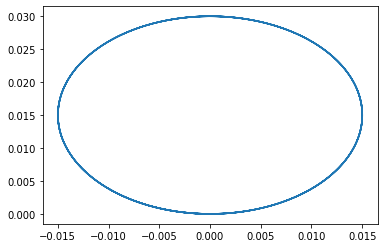

In [ ]:
for i in range(1,n):

    path[i] = (theta_r[i-1] + theta_l[i-1]) * r / 2                             # вычисление пройденного пути
    course[i] = (theta_r[i-1] - theta_l[i-1]) * r / B                           # вычисление курсового угла
    x[i] = x[i-1] + (path[i]-path[i-1]) * m.cos(course[i])                      # вычисление координаты X
    y[i] = y[i-1] + (path[i]-path[i-1]) * m.sin(course[i])                      # вычисление координаты Y

    control_l [i] = 2                                                           # задание управляющего напряжения левого двигателя
    control_r [i] = 3                                                           # задание управляющего напряжение правого двигателя

    motor_l = odeint(motor, state_l,[t[i-1],t[i]],args=(control_l [i],))        # вычисление угла поворота левого двигателя
    state_l = motor_l[1,:]                                                      # запоминание состояния левого двигателя 
    theta_l[i] = motor_l[1,1]                                                   # сохранение угла поворота левого двигателя
    motor_r = odeint(motor, state_r,[t[i-1],t[i]],args=(control_r [i],))        # вычисление угла поворота правого двигателя
    state_r = motor_r[1,:]                                                      # запоминание состояния правого двигателя 
    theta_r[i] = motor_r[1,1]                                                   # сохранение угла поворота правого двигателя

plt.plot(x, y)                                                                  # отрисовка результатов